# Statistics II. Homework 1

## Setup

In [5]:
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

### Ex 1

In [6]:
N = 500 

In [7]:
mu = np.array([2, 3])
sig1, sig2, rho = 3, 2, 0.67
cov = np.array([
    [sig1 ** 2, rho * sig1 * sig2],
    [rho * sig1 * sig2, sig2 ** 2]
])

In [8]:
x, y = np.random.multivariate_normal(mu, cov, N).T

Для побудови довірчого еліпсу скористуємось тим, що у випадку двовимірного нормалізованого нормального розподілу, власні числа і відповідні власні вектори коваріаційної матриці легко знайти аналітично, а саме

$$\lambda_1 = 1 + \rho, \quad \vec{v_1} = [1,\  1]^T$$
$$\lambda_2 = 1 - \rho, \quad \vec{v_2} = [1,\ -1]^T$$

де $\rho$ -- коефіціент кореляції Пірсона (не діагональний елемент матирці коваріації).

Для не нормалізованого розподілу отриманий еліпс треба відмасштабувати на $\sigma_1$ і $\sigma_2$ вздовж $x$ та $y$ відповідно

In [9]:
def confidence_ellipse(x, y, ax, level=0.95, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * sci.stats.norm.ppf(level)
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * sci.stats.norm.ppf(level)
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

In [10]:
coefs = np.polyfit(x, y, 1)
regr_xy = np.poly1d(coefs)

coefs = np.polyfit(y, x, 1)
regr_yx = np.poly1d(coefs)

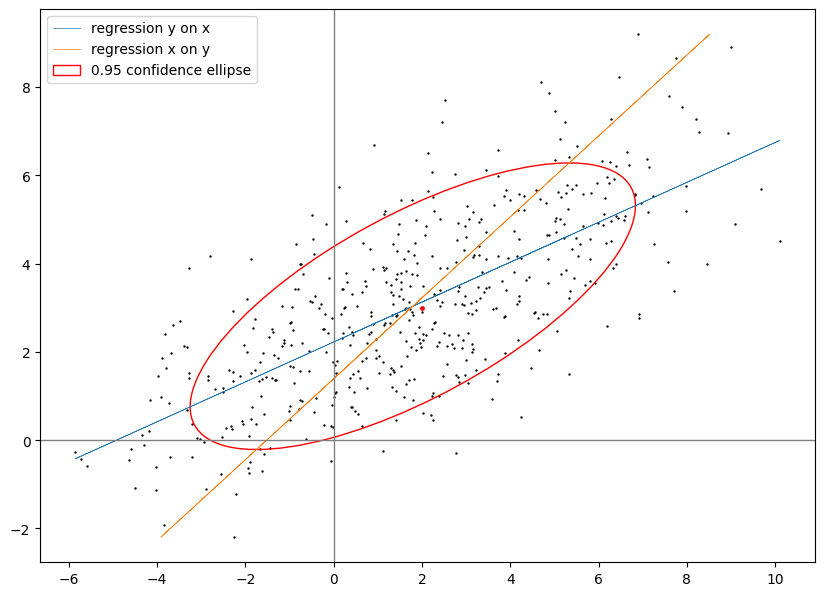

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, s=0.5, color='black')
ax.plot(x, regr_xy(x), lw=0.5, label='regression y on x')
ax.plot(regr_yx(y), y, lw=0.5, label='regression x on y')

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.set_aspect("equal")

ax.add_patch(
    confidence_ellipse(x, y, ax, edgecolor='red', level=0.95, label='0.95 confidence ellipse')
)

ax.scatter(mu[0], mu[1], c='red', s=6)

ax.legend()

plt.show()

З побудови довірчого еліпсу зрозуміло, що $\sigma_1$ і $\sigma_2$ відповідають за масштабування еліпсу вздовж прямих $y=x$ і $y=-x$ відповідно. Кореляція ($\rho$) відповідає за відношення довжин осей еліпсу до масштабування (тобто при $\sigma_1 = \sigma_2$), а саме:

1. $\rho > 0 \Rightarrow \lambda_1 > \lambda_2 \Rightarrow$ еліпс більше видовжений по прямій $y=x$
1. $\rho = 0 \Rightarrow \lambda_1 = \lambda_2 \Rightarrow$ еліпс вироджується в коло 
1. $\rho < 0 \Rightarrow \lambda_1 < \lambda_2 \Rightarrow$ еліпс більше видовжений по прямій $y=-x$

І загалом більший модуль $\rho$ відповідає більшому розтягненню еліпса.

Продемонструємо це на прикладі

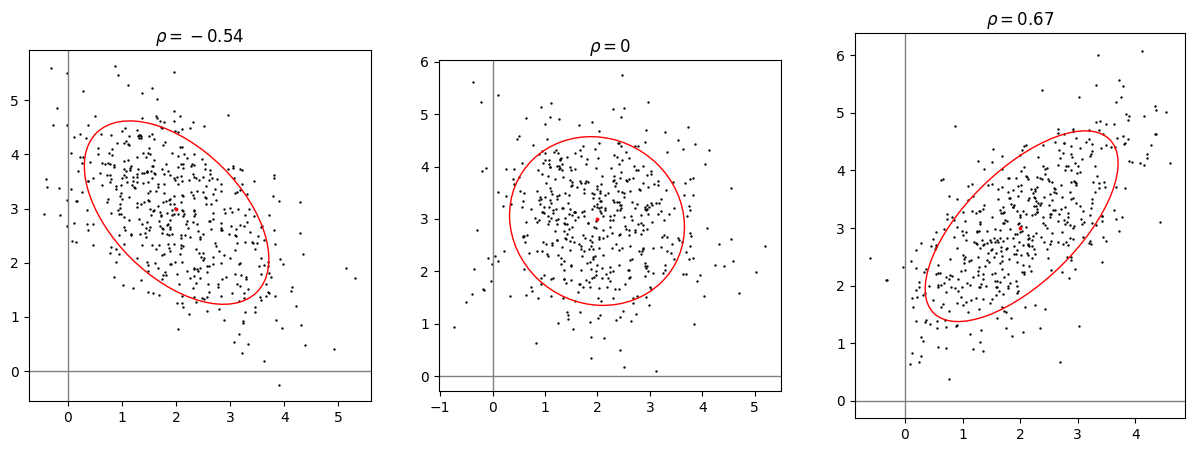

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

rhos = (-0.54, 0, 0.67)
sig1 = 1
sig2 = 1

for i in range(3):
    rho = rhos[i]
    cov = np.array([
        [sig1 ** 2, rho * sig1 * sig2],
        [rho * sig1 * sig2, sig2 ** 2]
    ])
    x, y = np.random.multivariate_normal(mu, cov, N).T

    ax = axs[i]
    ax.set_title(fr"$\rho = {rho}$")
    ax.scatter(x, y, s=0.5, color='black')

    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    ax.set_aspect("equal")

    ax.add_patch(
        confidence_ellipse(x, y, ax, edgecolor='red', level=0.95)
    )

    ax.scatter(mu[0], mu[1], c='red', s=3)

plt.show()

## Ex 2 (Rencher 5.18 a, b)

### a)

In [13]:
cols = ["group"] + [f"y{i+1}" for i in range(6)]
df = pd.read_table("data/T5_6_PILOT.DAT", header=None, sep="\s+", names=cols)

In [14]:
df1 = df[df.group == 1].drop(columns=['group'])
df2 = df[df.group == 2].drop(columns=['group'])

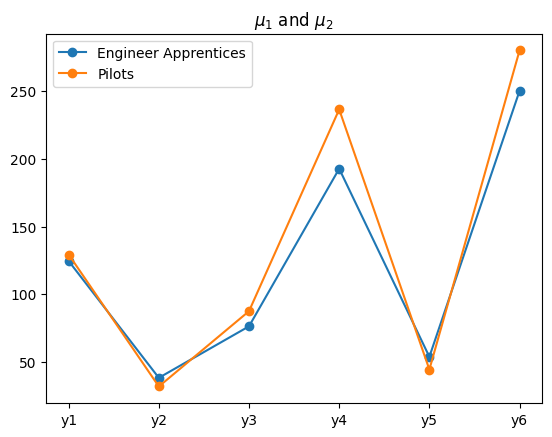

In [42]:
df1.mean().plot(marker='o', label='Engineer Apprentices')
df2.mean().plot(marker='o', label='Pilots')
plt.legend()
plt.title(r"$\mu_1$ and $\mu_2$")
plt.show()

In [26]:
n1, n2 = df1.shape[0], df2.shape[0]
p = df1.shape[1]

In [50]:
mu1, mu2 = df1.mean(), df2.mean()
sig1, sig2 = df1.cov(), df2.cov()
spl = (sig1 * (n1 - 1) + sig2 * (n2 - 1)) / (n1 + n2 - 2)
T2 = (n1 * n2) / (n1 + n2) * np.sqrt(mu1.T @ np.linalg.inv(spl) @ mu2)
F = T2 * (n1 + n2 - p - 1) / (p * (n1 + n2 - 2))
F

22.55629516907352

In [51]:
sci.stats.f.ppf(0.95, p, n1+n2-p-1)

2.389393897988133

Відхиляємо $H_0$, оскільки $F$-статистика більша за порогове значення

In [52]:
sig1

,y1,y2,y3,y4,y5,y6
y1,384.263158,20.736842,81.315789,26.605263,-15.921053,82.894737
y2,20.736842,68.200000,9.557895,26.868421,-64.068421,6.705263
y3,81.315789,9.557895,121.115789,-37.789474,0.021053,-4.063158
y4,26.605263,26.868421,-37.789474,1000.197368,-24.355263,-8.657895
y5,-15.921053,-64.068421,0.021053,-24.355263,322.450000,-132.205263
y6,82.894737,6.705263,-4.063158,-8.657895,-132.205263,470.221053


In [53]:
sig2

,y1,y2,y3,y4,y5,y6
y1,687.800000,69.305263,-52.178947,76.968421,-1.447368,439.200000
y2,69.305263,51.694737,3.336842,-46.968421,-35.342105,56.484211
y3,-52.178947,3.336842,110.884211,43.852632,-7.947368,-111.873684
y4,76.968421,-46.968421,43.852632,792.568421,8.157895,129.768421
y5,-1.447368,-35.342105,-7.947368,8.157895,173.671053,116.210526
y6,439.200000,56.484211,-111.873684,129.768421,116.210526,1253.747368


### b)

In [78]:
for col in df1.columns:
    res = sci.stats.ttest_ind(df1[col], df2[col], equal_var=True)
    print(f"{col}\t statistic: {res.statistic:.3f}\t pvalues: {res.pvalue:.4f}\t H0 rejected: {bool(res.pvalue < 0.05)}")


y1	 statistic: -0.656	 pvalues: 0.5160	 H0 rejected: False
y2	 statistic: 2.614	 pvalues: 0.0128	 H0 rejected: True
y3	 statistic: -3.288	 pvalues: 0.0022	 H0 rejected: True
y4	 statistic: -4.632	 pvalues: 0.0000	 H0 rejected: True
y5	 statistic: 1.887	 pvalues: 0.0668	 H0 rejected: False
y6	 statistic: -3.220	 pvalues: 0.0026	 H0 rejected: True


## Ex 3 (Rencher 5.20 a)

In [81]:
cols = ["group"] + [f"y{i+1}" for i in range(4)]
df = pd.read_table("data/T5_8_GOODS.DAT", header=None, sep="\s+", names=cols)

In [83]:
df1 = df[df.group == 1].drop(columns=['group'])
df2 = df[df.group == 2].drop(columns=['group'])

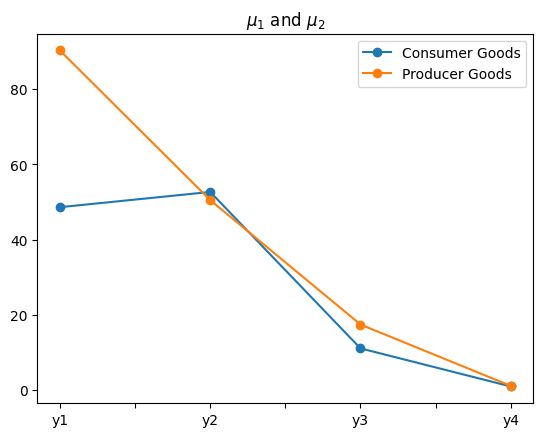

In [85]:
df1.mean().plot(marker='o', label='Consumer Goods')
df2.mean().plot(marker='o', label='Producer Goods')
plt.legend()
plt.title(r"$\mu_1$ and $\mu_2$")
plt.show()

In [90]:
n1, n2 = df1.shape[0], df2.shape[0]
p = df1.shape[1]

In [91]:
mu1, mu2 = df1.mean(), df2.mean()
sig1, sig2 = df1.cov(), df2.cov()
spl = (sig1 * (n1 - 1) + sig2 * (n2 - 1)) / (n1 + n2 - 2)
T2 = (n1 * n2) / (n1 + n2) * np.sqrt(mu1.T @ np.linalg.inv(spl) @ mu2)
F = T2 * (n1 + n2 - p - 1) / (p * (n1 + n2 - 2))
F

8.556926724869777

In [92]:
sci.stats.f.ppf(0.95, p, n1+n2-p-1)

3.112249847961388

Відхиляємо $H_0$, оскільки $F$-статистика більша за порогове значення